# Time series clustering exercise

# Data

Download the census bureau business data for all years 1993-2014. You can investigate using the API (I have not done it with the census bureau). I did is as you see below

The data is on the github repo. Each file is the economic census for 1 year. 
Download it programmatically and move it to PUIdata

 Download the NYC zipcodes shapefile. One of many ways in which you can get the zipcodes shapefile for NYC
 https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip


## You can use zipfile module in python to unzip the files
it should be installed in your system, but if it is not you can get the code with wget from here
https://github.com/python/cpython/blob/2.7/Lib/zipfile.py
remembering to use the raw link
(or you can use the usual shell commands)

In [1]:
import pandas as pd
import urllib
import os
import sys
import geopandas as gp
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl

from sklearn.cluster import KMeans

%matplotlib inline
import zipfile 
# zf = zipfile.ZipFile(fname)
# df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))

In [2]:
'''PRINT ALL THE NULL ROWS OF A DATAFRAME'''
def check_null(df):
    print(df[df.isnull().any(axis=1)][df.columns[df.isnull().any()]])

In [3]:
os.environ["PUIDATA"] = "%s/PUIdata"%os.getenv("HOME")
puidata = os.getenv("PUIDATA")
puidata

'/nfshome/gw1054/PUIdata'

In [4]:
url = 'https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip'
urllib.request.urlretrieve(url, 'ZIP_CODE_040114.zip')
!unzip -o ZIP_CODE_040114.zip -d $PUIDATA

Archive:  ZIP_CODE_040114.zip
  inflating: /nfshome/gw1054/PUIdata/ZIP_CODE_040114.shx  
  inflating: /nfshome/gw1054/PUIdata/ZIP_CODE_040114.dbf  
  inflating: /nfshome/gw1054/PUIdata/ZIP_CODE_040114.prj  
  inflating: /nfshome/gw1054/PUIdata/ZIP_CODE_040114.sbn  
  inflating: /nfshome/gw1054/PUIdata/ZIP_CODE_040114.sbx  
  inflating: /nfshome/gw1054/PUIdata/ZIP_CODE_040114.shp  
  inflating: /nfshome/gw1054/PUIdata/ZIP_CODE_040114.shp.xml  


# Data cleaning

you may need to clean your data: for some NYC zip codes there may be no info

sanity check: you should have 20 (N_timestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)


IMPORTANT: read the instructions below on pre-processing. Afte rthat:

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



## TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means
    in **a few** clusters (as discussed there is no real good, sound way to 
    decide what a good number is here. try a few options, keeping in mind 
    a few is more than a couple, but i recommand you stay within the 
    single digit numbers)
    
    3. plot the cluster centers (if you used K means those are the means of 
    the clusters). you can plot for example the cluster centers overlayed on 
    each time series (using the alpha channel to control the opacity in the 
    plot may be helpful here).
    
    4. Use another clustering algorithm (of your choice)
    
    5. overlay your data on a NYC map: you can use shapefiles for the 
    zip codes and different colors for different clusters
    
    6. Compare the results of the 2 algorithms
    
    7. attempt an interpretation. this is dangerous ground: clustering is 
    an exploratory tool so you do not want to jump to conclusions because 
    you see some clusters! but seeing structure in your data can inform 
    your next moves as an investigator. 
    

Note on preprocessing: the preparation of these data should include the "standardization" of the time seris. 
*Always when you apply a moachine learning model you should standardize the data or whiten it.*
These operations may be complicated preprocessing operation, they can for example invoke PCA, and they are aimed at removing covariance in the feature space.

The simplest version of whitening *standardizes each feature*" from every column (feature) you subtract the mean and you divide it by the standard deviation.

But the time series preprocessing is different if you want to use each time stamp as feature: because you want to maintain the coherence of the data, i.e. you **do not want** to treat each feature as an independent feature! the pattenrs in the time series are what you are clustering on (time series goes up and down, creating a pattern) and those patterns would be lost by whitening.

*So when you cluster or otherwise use a time series in a model, using each timestamp as a feature, you want to standardize the observations, not the features.* 

**From each row of your table (observation, in this case each zipcode) subtract the mean and you divide the row by the standard deviation.**

In [5]:
nyczipsshp = gp.read_file(os.getenv("PUIDATA") + "/ZIP_CODE_040114.shp")
#nyczipsshp.plot()
#nyczipsshp.drop_duplicates("ZIPCODE").plot()
#nyczipsshp
print("ZIPCODES:",
      len(np.unique(nyczipsshp.ZIPCODE)), "POLYGONS:",
      len(nyczipsshp.ZIPCODE),
      "the difference is due to island with same zip as parts of land,",
      "but disjoint shapes")
nyczips = nyczipsshp.ZIPCODE.values.astype(int)
print("number of NYC zip codes:", len(nyczips))

ZIPCODES: 248 POLYGONS: 263 the difference is due to island with same zip as parts of land, but disjoint shapes
number of NYC zip codes: 263


In [6]:
# 20 years of data and 263 zipcodes
nyczipsshp.shape

(263, 13)

In [7]:
nyczipsshp = nyczipsshp.drop_duplicates("ZIPCODE")
nyczipsshp.shape

(248, 13)

In [8]:
nyczipsshp.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [9]:
files = []
for i in (list(range(94,100))+list(range(15))):
    files.append('zbp' + str(i).zfill(2) + 'totals')

In [10]:
path = puidata
for i in files:
    url = 'https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW12_fb55/' + i + '.zip'
    urllib.request.urlretrieve(url, puidata + '/' + i + '.zip')

In [11]:
# !unzip -o $PUIDATA/\*.zip -d $PUIDATA/

In [12]:
zipshp = pd.DataFrame(nyczipsshp[['ZIPCODE']])
df = pd.DataFrame()
for i in files:
    fname = puidata + '/' + i + '.zip'
    zf = zipfile.ZipFile(fname)
    temp = pd.read_csv(zf.open(fname.split('/')[4].replace('.zip','.txt')), 
                       usecols=[0, 6], names=['ZIPCODE', 'est%s'%i[3:5]])
#     temp = pd.read_csv(puidata + '/' + i + '.txt', usecols=[0, 6], names=['ZIPCODE', 'est%s'%i[3:5]])
    print(i, temp.shape)
    zipshp = pd.merge(zipshp, temp, on='ZIPCODE', how='left')
zipshp.head()

zbp94totals (39260, 2)
zbp95totals (39933, 2)
zbp96totals (40100, 2)
zbp97totals (40249, 2)
zbp98totals (39468, 2)
zbp99totals (39762, 2)
zbp00totals (39854, 2)
zbp01totals (39818, 2)
zbp02totals (39452, 2)
zbp03totals (39424, 2)
zbp04totals (39584, 2)
zbp05totals (39626, 2)
zbp06totals (39658, 2)
zbp07totals (39653, 2)
zbp08totals (39241, 2)
zbp09totals (39175, 2)
zbp10totals (39105, 2)
zbp11totals (39033, 2)
zbp12totals (38819, 2)
zbp13totals (38805, 2)
zbp14totals (38793, 2)


,ZIPCODE,est94,est95,est96,est97,est98,est99,est00,est01,est02,...,est05,est06,est07,est08,est09,est10,est11,est12,est13,est14
0,11436,51,50,53,51,51,58,65,57,78,...,82,80,6779,8380,8465,7434,7525,7114,6678,7147
1,11213,406,420,433,456,476,473,477,493,546,...,556,565,46188,49151,50915,53557,52653,54138,56554,57876
2,11212,505,494,502,527,519,541,520,527,577,...,587,570,101210,101521,98634,89904,90056,97423,101625,111326
3,11225,381,387,388,410,416,409,417,422,479,...,491,499,22398,23142,22037,23829,24286,25861,25809,27211
4,11218,985,1015,1049,1075,1118,1149,1161,1180,1228,...,1332,1331,61431,65839,66601,77377,78204,86442,90540,99885


In [13]:
# zipshp.drop_duplicates(keep=False, inplace=True)
zipshp.shape

(248, 22)

In [14]:
check_null(zipshp)

    est94 est95 est96 est97 est98 est99 est00 est01 est02 est03   ...   est05  \
47    964   990  1008   993  1235  1173  1254  1030   193   103   ...      69   
51    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   ...     NaN   
83    NaN   NaN     1     3     4     7     7     7    11    10   ...      11   
102     1   NaN   NaN     1   NaN   NaN     2     1     1   NaN   ...     NaN   
184   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   ...     NaN   
185   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   ...     NaN   
186   NaN   NaN   NaN   NaN     6    12    11    16    33    37   ...      43   
227     2     2     2     1     1     1     1     2     2     1   ...       1   
228   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   ...     NaN   
229     1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   ...       1   
230     4     3     2   NaN   NaN   NaN   NaN   NaN   NaN   NaN   ...     NaN   
231     2     3     2     4 

In [15]:
cleancsb = zipshp.drop('ZIPCODE', axis=1).astype(np.float)
cleancsb.index = zipshp.ZIPCODE.astype(np.int)
# cleancsb = cleancsb.fillna(0.)
# cleancsb = cleancsb.dropna()
cleancsb.head()

,est94,est95,est96,est97,est98,est99,est00,est01,est02,est03,...,est05,est06,est07,est08,est09,est10,est11,est12,est13,est14
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
11436,51.0,50.0,53.0,51.0,51.0,58.0,65.0,57.0,78.0,74.0,...,82.0,80.0,6779.0,8380.0,8465.0,7434.0,7525.0,7114.0,6678.0,7147.0
11213,406.0,420.0,433.0,456.0,476.0,473.0,477.0,493.0,546.0,569.0,...,556.0,565.0,46188.0,49151.0,50915.0,53557.0,52653.0,54138.0,56554.0,57876.0
11212,505.0,494.0,502.0,527.0,519.0,541.0,520.0,527.0,577.0,581.0,...,587.0,570.0,101210.0,101521.0,98634.0,89904.0,90056.0,97423.0,101625.0,111326.0
11225,381.0,387.0,388.0,410.0,416.0,409.0,417.0,422.0,479.0,488.0,...,491.0,499.0,22398.0,23142.0,22037.0,23829.0,24286.0,25861.0,25809.0,27211.0
11218,985.0,1015.0,1049.0,1075.0,1118.0,1149.0,1161.0,1180.0,1228.0,1247.0,...,1332.0,1331.0,61431.0,65839.0,66601.0,77377.0,78204.0,86442.0,90540.0,99885.0


In [16]:
cleancsb = cleancsb.dropna().fillna(value=0)
cleancsb.shape

(230, 21)

In [17]:
check_null(cleancsb)

Empty DataFrame
Columns: []
Index: []


In [18]:
#then the standardization will look like: N(miu=0, sigma=1)
vals = ((cleancsb.T - cleancsb.mean(1)) / cleancsb.std(1)).T
vals.head()
vals = vals.dropna()
print(max(vals.mean(1)), vals.mean(1).shape)
print(max(vals.std(1)), vals.std(1).shape)
vals.head()

2.0089749969407595e-16 (230,)
1.0000000000000002 (230,)


,est94,est95,est96,est97,est98,est99,est00,est01,est02,est03,...,est05,est06,est07,est08,est09,est10,est11,est12,est13,est14
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
11436,-0.764681,-0.764952,-0.764139,-0.764681,-0.764681,-0.762785,-0.760889,-0.763056,-0.757368,-0.758451,...,-0.756284,-0.756826,1.057707,1.491364,1.514387,1.235124,1.259773,1.148447,1.030349,1.157386
11213,-0.766089,-0.765552,-0.765052,-0.764169,-0.763401,-0.763516,-0.763363,-0.762748,-0.760713,-0.759830,...,-0.760329,-0.759983,0.991977,1.105759,1.173498,1.274953,1.240239,1.297264,1.390040,1.440806
11212,-0.763634,-0.763858,-0.763695,-0.763186,-0.763349,-0.762901,-0.763329,-0.763186,-0.762169,-0.762087,...,-0.761965,-0.762311,1.285440,1.291768,1.233025,1.055394,1.058486,1.208385,1.293884,1.491273
11225,-0.767073,-0.766570,-0.766486,-0.764643,-0.764140,-0.764727,-0.764056,-0.763637,-0.758861,-0.758107,...,-0.757856,-0.757186,1.077711,1.140050,1.047463,1.197613,1.235904,1.367872,1.363515,1.480987
11218,-0.754328,-0.753563,-0.752695,-0.752032,-0.750935,-0.750144,-0.749837,-0.749353,-0.748128,-0.747643,...,-0.745474,-0.745500,0.788069,0.900548,0.919992,1.194962,1.216065,1.426273,1.530842,1.769298


In [19]:
check_null(vals)

Empty DataFrame
Columns: []
Index: []


vals.mean(axis=1) should return 0 (or something very small) everywhere

vals.mean(axis=1).shape should be (260,)

vals.std(axis=1) should return 1 everywhere

vals.std(axis=1).shape

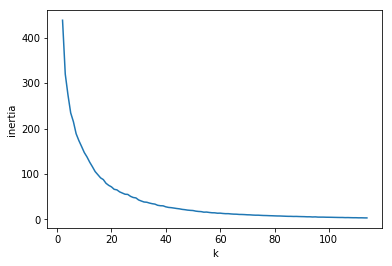

In [20]:
#cluster with kmeans
#try different k values
x = []; y = []
for k in range (2, ((len(vals))//2)):
    km = KMeans(n_clusters=k, random_state=444).fit(vals)
    x.append(k); y.append(km.inertia_)

# km = KMeans(n_clusters=nc, random_state=444).fit(vals)
plt.plot(x, y)
plt.xlabel('k')
plt.ylabel('inertia')

caption:[the elbow is at around 18 where the cost is not dropping as fast]

In [21]:
# refered from the graphs below, we should use 5 clusters
nc = 5
km = KMeans(n_clusters=nc, random_state=444).fit(vals)
km.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 0, 4, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 0, 0, 0, 2, 4, 2, 2, 2, 2,
       3, 0, 3, 3, 2, 0, 0, 2, 2, 4, 2, 1, 1, 1, 1, 1, 3, 2, 2, 2, 2, 2, 2], dtype=int32)

In [22]:
#each observation in the km object has a label: 
#that is the cluster assigned to that observation
labels = km.labels_
km.labels_.shape

(230,)

In [23]:
labels[0:5]

array([2, 2, 2, 2, 2], dtype=int32)

### The map of the clusters may look something like this

In [24]:
z = vals.copy()
z['label'] = labels

In [25]:
z.head()

,est94,est95,est96,est97,est98,est99,est00,est01,est02,est03,...,est06,est07,est08,est09,est10,est11,est12,est13,est14,label
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
11436,-0.764681,-0.764952,-0.764139,-0.764681,-0.764681,-0.762785,-0.760889,-0.763056,-0.757368,-0.758451,...,-0.756826,1.057707,1.491364,1.514387,1.235124,1.259773,1.148447,1.030349,1.157386,2
11213,-0.766089,-0.765552,-0.765052,-0.764169,-0.763401,-0.763516,-0.763363,-0.762748,-0.760713,-0.759830,...,-0.759983,0.991977,1.105759,1.173498,1.274953,1.240239,1.297264,1.390040,1.440806,2
11212,-0.763634,-0.763858,-0.763695,-0.763186,-0.763349,-0.762901,-0.763329,-0.763186,-0.762169,-0.762087,...,-0.762311,1.285440,1.291768,1.233025,1.055394,1.058486,1.208385,1.293884,1.491273,2
11225,-0.767073,-0.766570,-0.766486,-0.764643,-0.764140,-0.764727,-0.764056,-0.763637,-0.758861,-0.758107,...,-0.757186,1.077711,1.140050,1.047463,1.197613,1.235904,1.367872,1.363515,1.480987,2
11218,-0.754328,-0.753563,-0.752695,-0.752032,-0.750935,-0.750144,-0.749837,-0.749353,-0.748128,-0.747643,...,-0.745500,0.788069,0.900548,0.919992,1.194962,1.216065,1.426273,1.530842,1.769298,2


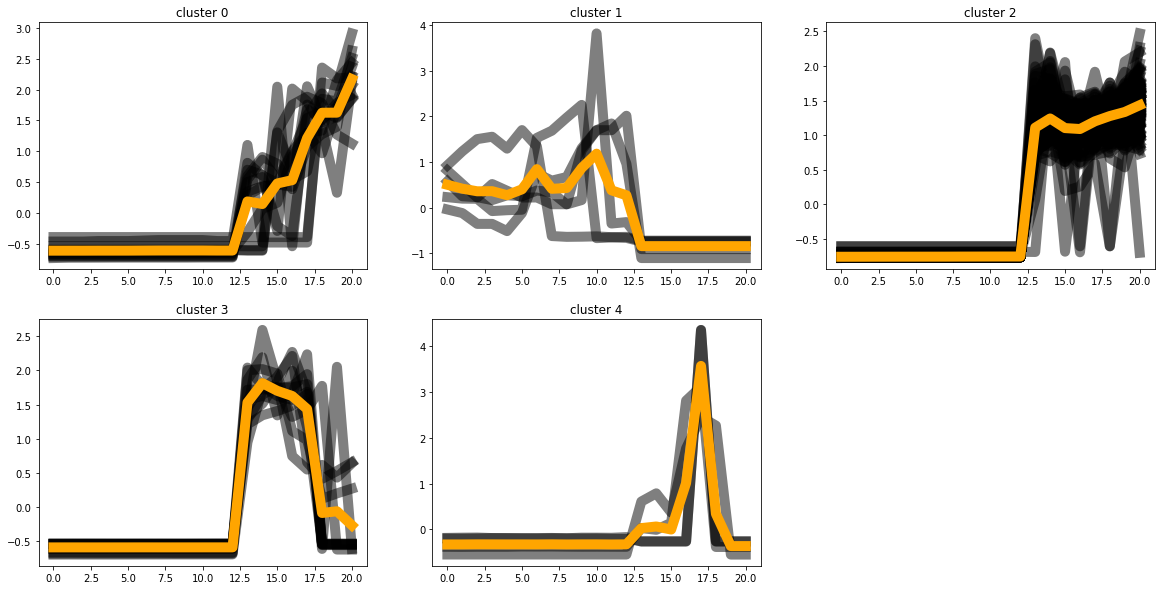

In [26]:
fig = plt.figure(figsize=(20,10))
for i in range(nc):
    temp = pd.DataFrame(z[z['label'] == i])
    ax = fig.add_subplot(2,3,i+1)
    for j in range(temp.shape[0]):
        ax.plot(range(21), temp.iloc[j].dropna()[:-1], 'black', alpha=0.5, linewidth=10)
        ax.set_title('cluster %d'%i)
    ax.plot(range(21), temp.mean(0).iloc[:-1], 'orange', linewidth=10)

Caption[Plot of the five clusters and their means]

In [27]:
gtemp = gp.GeoDataFrame(nyczipsshp[['ZIPCODE', 'geometry']].dropna().fillna(value=0))
gtemp.index = gtemp.ZIPCODE.astype(np.float)
gtemp.drop('ZIPCODE', axis=1, inplace=True)
gtemp.head()

,geometry
ZIPCODE,
11436.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
11213.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
11212.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
11225.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
11218.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [28]:
ggg = gp.GeoDataFrame(pd.concat([z, gtemp], axis=1))
ggg = ggg.dropna()

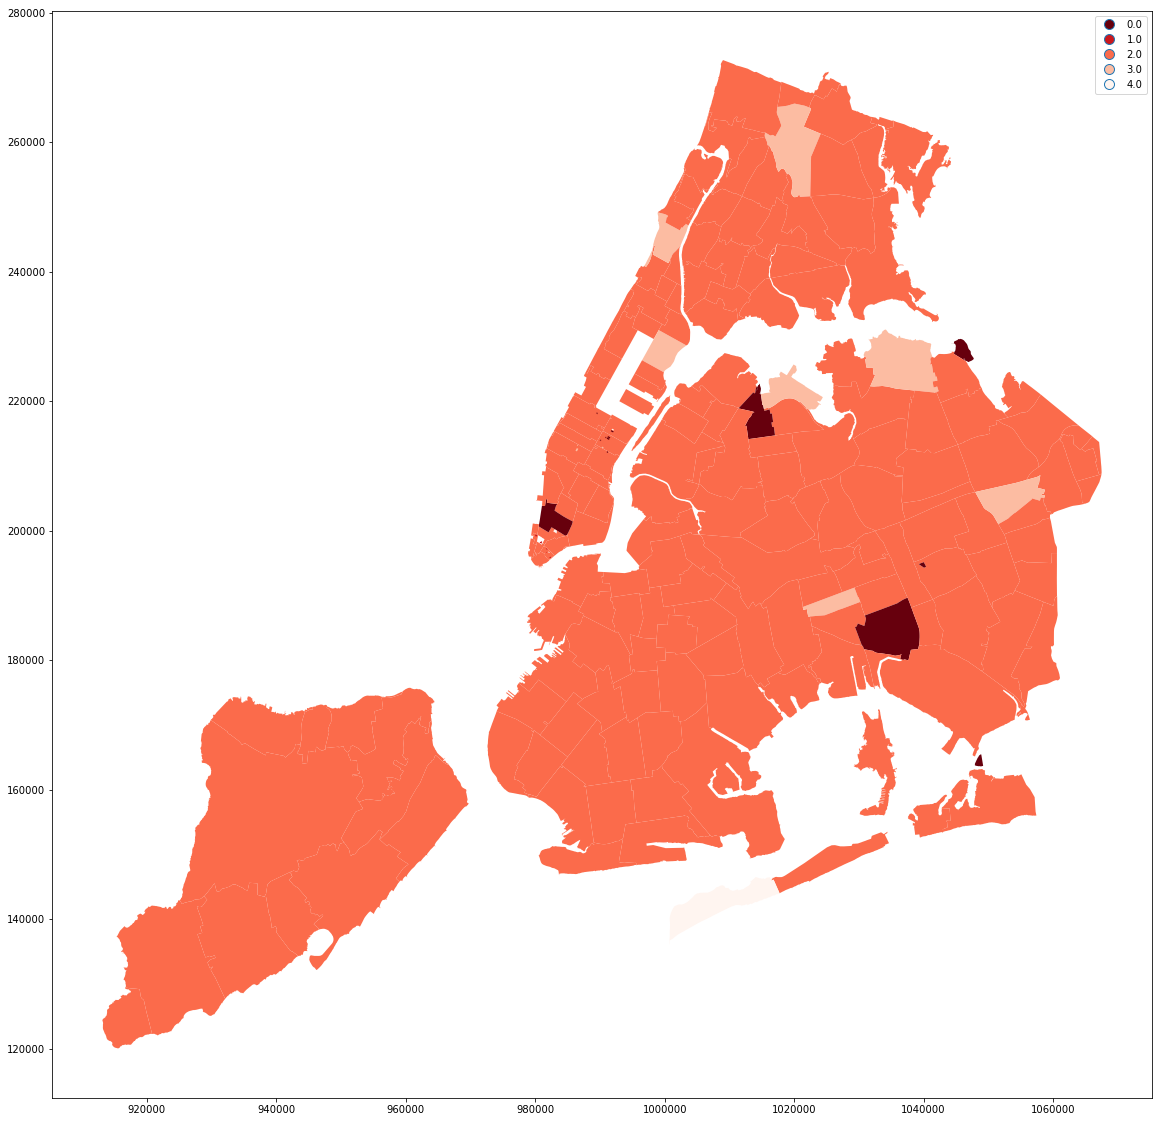

In [29]:
ggg.plot(column='label', legend=True, categorical=True, cmap='Reds_r', figsize=(20,20))

Caption[Coropleth of the clusters on the map]

### And if you use hierarchical clustering in scipy you can make a dandrogram it may look like this:

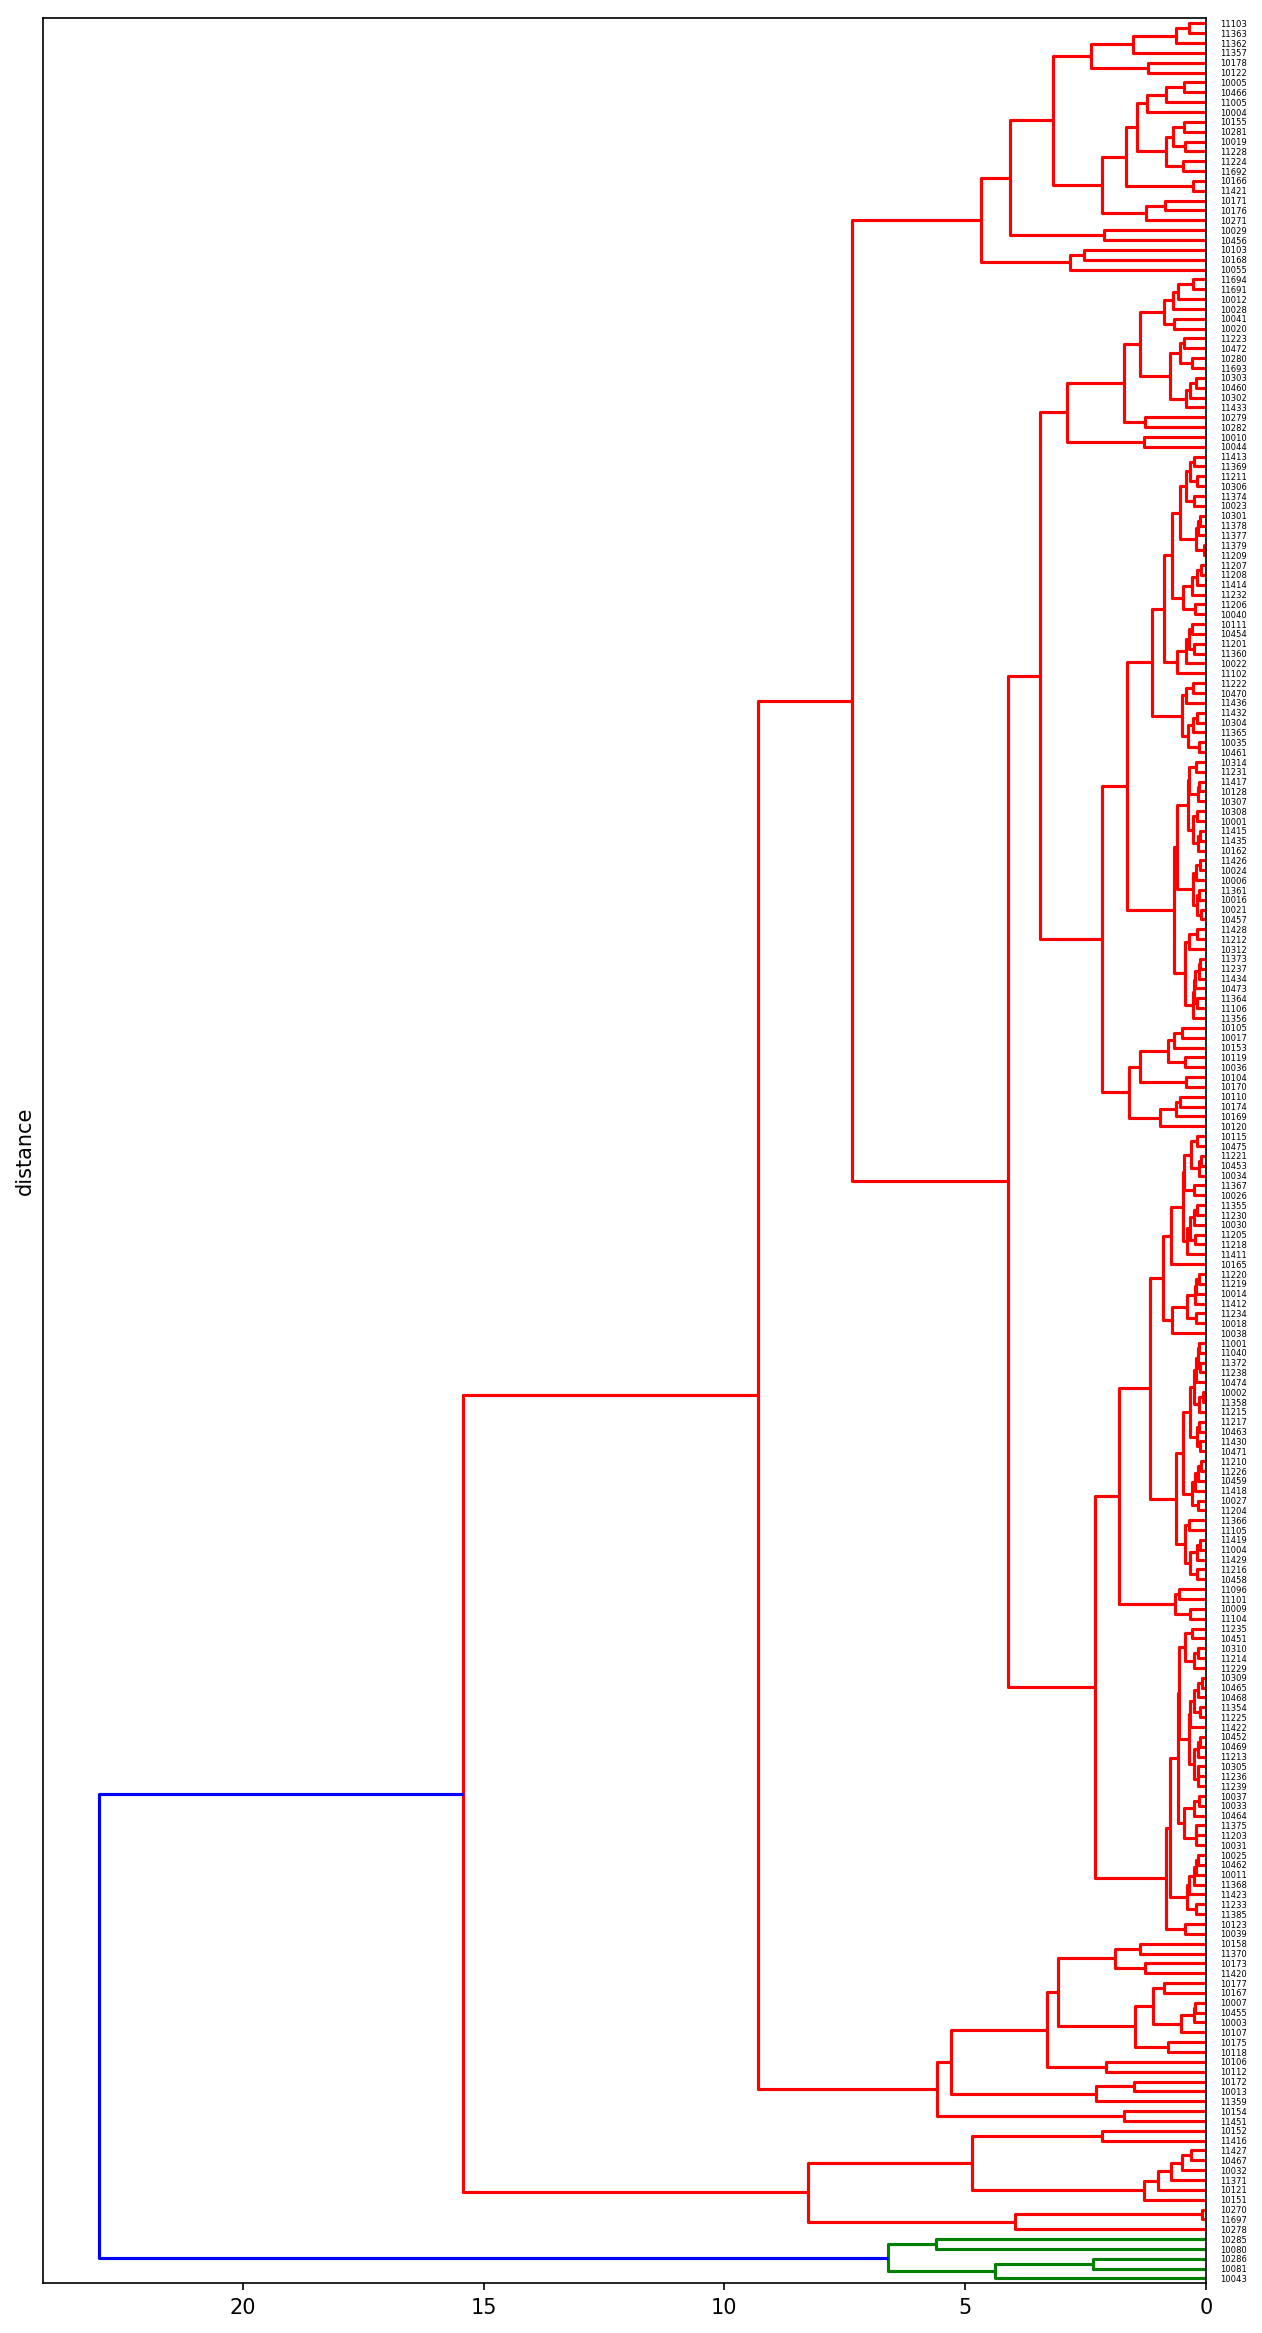

In [30]:
import scipy.cluster as scp
fig = pl.figure(figsize=(10,20), dpi=150)
pl.ylabel("distance")
ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(vals, method='ward'),
                               labels = z.index.astype(str),
                               leaf_rotation=0.,  # rotates the x axis labels
                               leaf_font_size=4.,
                               orientation='left')  # font size for the x axis labels)


Caption:[Result of the hierarchical clustering]

# Compare two algorithms and interpretate

hierarchical clustering only produced two clusters, but according to the elbow plot, there should be as many as 18 clusters